# Tutorial
## 1) Targeted Adversarial Examples (Carlini & Wagner and related methods)
First, we need to import the necessary modules.

In [1]:
%load_ext autoreload
%autoreload 2

# built-in libraries
import os 

# third party libraries
import matplotlib.pyplot as plt 
import numpy as np
import tqdm
import torch 
import torch.nn.functional as func

# repository modules
import models
import train
import dataset
import utils

The training and test data is loaded in memory using the `dataset` local module. Before using the FAUST dataset download it from [here](http://faust.is.tue.mpg.de/) and place it in `{repository-root}/datasets/faust/raw/`.

In [2]:
REPO_ROOT = os.path.join(os.path.dirname(os.path.realpath('__file__')),"..")
FAUST = os.path.join(REPO_ROOT,"datasets/faust")
PARAMS_FILE = os.path.join(REPO_ROOT, "model_data/data.pt")

traindata = dataset.FaustDataset(FAUST, train=True, test=False, transform_data=True)
testdata = dataset.FaustDataset(FAUST, train=False, test=True,  transform_data=True)

C:\Users\giorg\Anaconda3\envs\adex\lib\site-packages\torch_geometric\data\dataset.py:94: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you really want to make use of another pre-processing technique, make sure to delete `C:\Users\giorg\Adversarial-Examples-on-Meshes\datasets\faust\processed/processed` first.
  self.processed_dir))


Then we can define the classifier for the human pose classefication task; download the classifier parameters from [here](https://drive.google.com/open?id=1IllCPPPcqFL3v8BDxCyswzEpxoGyXvMe). Move these parameters in `{repository-root}/model_data/data.pt` .

In [3]:
model = models.ChebnetClassifier(
    param_conv_layers=[128,128,64,64],
    D_t = traindata.downscale_matrices,
    E_t = traindata.downscaled_edges,
    num_classes = traindata.num_classes,
    parameters_file=PARAMS_FILE)

Training and evaluation can be done through the `train` local module.

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.77it/s]


tensor(0.9000)


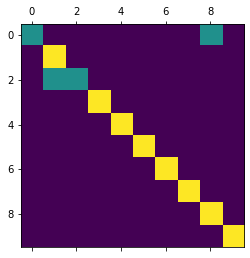

In [4]:
#train network
train.train(
    train_data=traindata,
    classifier=model,
    parameters_file=PARAMS_FILE,
    epoch_number=0)

#compute accuracy
accuracy, confusion_matrix = train.evaluate(eval_data=testdata, classifier=model)

print(accuracy)
plt.matshow(confusion_matrix)
plt.show()

### Generating Targeted Adversarial Examples

In [18]:
from adversarial.carlini_wagner import CWBuilder # module containing the adversarial targeted algorithm

# get a random mesh from the dataset and a random target class
import random
i = random.randint(0, len(testdata)-1)
x = testdata[i].pos
e = testdata[i].edge_index.t() # needs to be transposed
f = testdata[i].face.t() # needs to be transposed
y = testdata[i].y
t = random.randint(0, testdata.num_classes-1)
eigs_num = 36

# configure adversarial example components
builder = CWBuilder(search_iterations=1)
builder.set_classifier(model)
builder.set_mesh(x, e, f)
builder.set_target(t)

params = {
    CWBuilder.USETQDM:True,CWBuilder.MIN_IT:100,
    CWBuilder.LEARN_RATE:1e-4,CWBuilder.ADV_COEFF:1e-2}

adex = builder.build(**params)
print("adversarial attack: "+("successful" if adex.is_successful else "unsuccessful"))


[0,0.01] ; c=0.01









  0%|                                                                                          | 0/100 [00:00<?, ?it/s]






  1%|▊                                                                                 | 1/100 [00:01<02:23,  1.45s/it]






  2%|█▋                                                                                | 2/100 [00:02<02:22,  1.46s/it]






  3%|██▍                                                                               | 3/100 [00:04<02:23,  1.48s/it]






  4%|███▎                                                                              | 4/100 [00:05<02:21,  1.48s/it]






  5%|████                                                                              | 5/100 [00:07<02:21,  1.48s/it]






  6%|████▉                                                                             | 6/100 [00:08<02:20,  1.49s/it]






  7%|█████▋                                                                            | 7/100 [00:10<02:18,  1

KeyboardInterrupt: 

We can finally see the actual adversarial example using **Plotly** (note: you need to install plotly before-hand)

In [24]:
import plotly
import plotly.graph_objects as go
import numpy as np

def visualize(pos, faces, intensity=None):
  cpu = torch.device("cpu")
  if type(pos) != np.ndarray:
    pos = pos.to(cpu).clone().detach().numpy()
  if pos.shape[-1] != 3:
    raise ValueError("Vertices positions must have shape [n,3]")
  if type(faces) != np.ndarray:
    faces = faces.to(cpu).clone().detach().numpy()
  if faces.shape[-1] != 3:
    raise ValueError("Face indices must have shape [m,3]") 
  if intensity is None:
    intensity = np.ones([pos.shape[0]])
  elif type(intensity) != np.ndarray:
    intensity = intensity.to(cpu).clone().detach().numpy()

  x, z, y = pos.T
  i, j, k = faces.T

  mesh = go.Mesh3d(x=x, y=y, z=z,
            color='lightpink',
            intensity=intensity,
            opacity=1,
            colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']],
            i=i, j=j, k=k,
            showscale=True)
  layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

  #pio.renderers.default="plotly_mimetype"
  fig = go.Figure(data=[mesh],
                  layout=layout)
  fig.update_layout(
      autosize=True,
      margin=dict(l=20, r=20, t=20, b=20),
      paper_bgcolor="LightSteelBlue")
  fig.show()
    
def compare(pos1, faces1, pos2, faces2):
    n,m = pos1.shape[0], pos2.shape[0]
    tmpx = torch.cat([pos1, pos2],dim=0)
    tmpf = torch.cat([faces1, faces2+n], dim=0)
    color = torch.zeros([n+m],dtype=pos1.dtype, device=pos1.device)
    color[n:] = (pos1-pos2).norm(p=2,dim=-1)
    visualize(tmpx, tmpf,color)

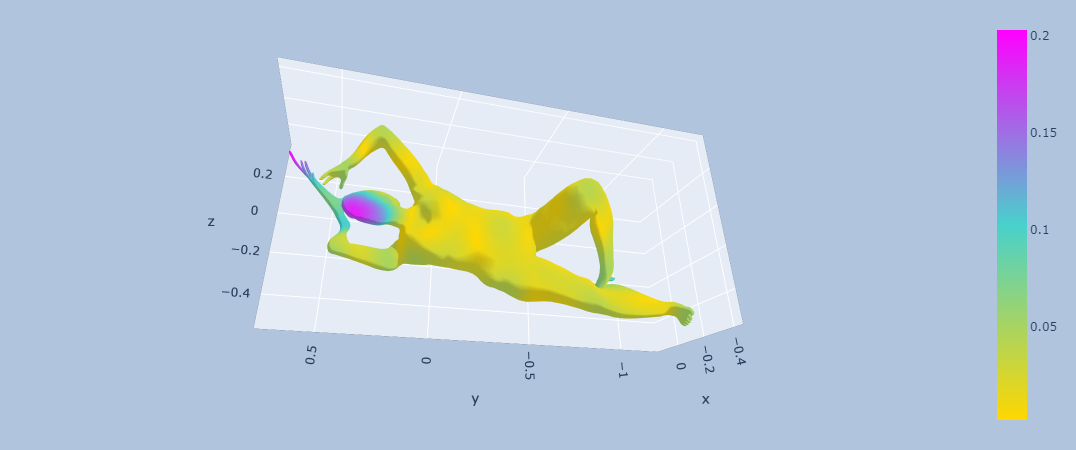

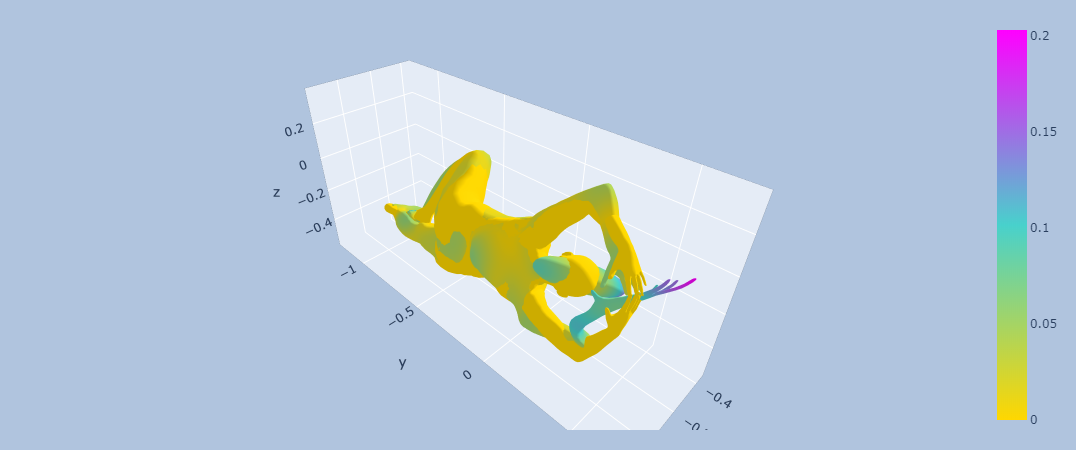

In [25]:
visualize(adex.perturbed_pos, f, (x-adex.perturbed_pos).norm(p=2,dim=-1))
compare(adex.pos, f, adex.perturbed_pos,f)

### Projected Gradient Descent Method

In [ ]:
from os import mkdir, listdir
from os.path import exists, join 
import random
import tqdm

import adversarial.pgd as pgd
import adversarial.carlini_wagner as cw
import numpy as np

def save_adex(adex, y, filename):
  ppos = adex.perturbed_pos.detach().clone().cpu().numpy()
  pos = adex.pos.detach().clone().cpu().numpy()
  edges = adex.edges.detach().clone().cpu().numpy()
  faces = adex.faces.detach().clone().cpu().numpy()
  is_successful = adex.is_successful
  
  data = {"perturbed-positions":ppos,
   "positions":pos,
   "edges":edges,
   "faces":faces,
    "y":y,
    "success":is_successful,
   "l2":cw.L2_distortion(adex).item(),
   "arap":cw.LocallyEuclideanDistortion(K=40)(adex).item()
   }
  np.save(filename, data, allow_pickle=True)

def pgd_experiments(projection_type, builder_type, model, data, folder="tmp"):
    projections = {"lowband":         pgd.lowband_filter,
                  "lowband-clip":     lambda a,x: pgd.clip(a, pgd.lowband_filter(a,x)),
                  "lowband-clipnorm": lambda a,x: pgd.clip_norms(a,pgd.lowband_filter(a,x)),
                   "none":            lambda y,z : z,
                  "clip":             pgd.clip,
                  "clipnorm":         pgd.clip_norms}

    builders = {"sign":(pgd.PGDBuilder,0.01), "l2":(pgd.L2PGDBuilder, 1)}
    successes, failures = 0,0
    
    if not exists(folder):
        mkdir(folder)
    
    for i in tqdm.tqdm(range(len(data))):
        x = data[i].pos
        e = data[i].edge_index.t()
        f = data[i].face.t() 
        y = data[i].y
            
        if model(x).argmax() == y:
            tmp, alpha = builders[builder_type]
            builder = tmp().set_iterations(7).set_epsilon(0.045).set_alpha(alpha).set_eigs_number(50)
            builder.set_projection(projections[projection_type])
            builder.set_mesh(x,e,f).set_classifier(model)
            adex = builder.build(usetqdm="standard")
            print("successful: {}".format(adex.is_successful))
            #print("adversarial example's prediction: {}".format(model(adex.perturbed_pos).argmax()))
            #print("ground-truth: {}".format(model(adex.pos).argmax()))
            #visualize(adex.pos, f, (adex.pos-adex.perturbed_pos).norm(dim=-1,p=2))
            #compare(adex.pos, f, adex.perturbed_pos, f)
            
            filename = join(folder, "adversarial_{}_b{}_p{}".format(i, builder_type, projection_type))
            save_adex(adex, y, filename)
            successes +=1
        else:
            print("skip")
            failures +=1
    return successes/(successes+failures)


pgd_experiments("lowband","l2", model=model, data=testdata, folder=join(REPO_ROOT,"pgd_tests_l2_lowband"))
pgd_experiments("none","l2", model=model, data=testdata, folder=join(REPO_ROOT,"pgd_tests_l2"))

pgd_experiments("lowband","sign", model=model, data=testdata, folder=join(REPO_ROOT,"pgd_tests_sign_lowband"))
pgd_experiments("none", "sign", model=model, data=testdata, folder=join(REPO_ROOT,"pgd_tests_sign"))
                                                                    
                                                                    
pgd_experiments("lowband-clipnorm","l2", model=model, data=testdata, folder=join(REPO_ROOT,"pgd_tests_l2_lowband-clipnorm"))
pgd_experiments("clipnorm","l2", model=model, data=testdata, folder=join(REPO_ROOT,"pgd_tests_l2_clipnorm"))
                                                                    
                                                                    
pgd_experiments("lowband-clipnorm","sign", model=model, data=testdata, folder=join(REPO_ROOT,"pgd_tests_sign_lowband-clipnorm"))
pgd_experiments("clipnorm","sign", model=model, data=testdata, folder=join(REPO_ROOT,"pgd_tests_sign_clipnorm"))

## 2) Untargeted (FSGM and related methods)

[autoreload of adversarial.base failed: Traceback (most recent call last):
  File "C:\Users\giorg\Anaconda3\envs\adex\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\giorg\Anaconda3\envs\adex\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\giorg\Anaconda3\envs\adex\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\giorg\Anaconda3\envs\adex\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\giorg\Adversarial-Examples-on-Meshes\src\adversarial\base.py", line 7, in <module>
    class AdversarialExample(object):
  File "C:\Users\giorg\Adver

torch.dtype